In [144]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
from loadcreon import LoadCreon
from creonmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer
from semisuperhelper import SemiSupervisedHelper
from pnuwrapper import PNUWrapper
from jeffsearchcv import JeffRandomSearchCV
from nestedcross import NestedCV
from frankenscorer import FrankenScorer, extract_scores_from_nested, extract_score_grid
from searchrf import save_search, load_search

In [3]:
path = "C:\Data\\010317\membership14_final_0103.txt"
lc = LoadCreon(path)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [5]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

In [146]:
rf_param_search = {'base_estimator__n_estimators':sp.stats.randint(low=10, high=500),
                   'num_unlabeled':sp.stats.randint(low=0, high=15000),
                   'pu_learning':[False, True],
                   'base_estimator__max_features':['sqrt','log2',5, 10, 20, 50, None],
                   #todo - make custom rvs for this type of thing where I want a None some % of the time
                   'base_estimator__max_depth':sp.stats.randint(low=2, high=50),
                   'base_estimator__min_samples_split':[2,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.07,0.09,0.1,0.12,0.15,0.17,0.2,0.25],
                   'base_estimator__min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,50,100],
                   'base_estimator__class_weight':[None,'balanced','balanced_subsample']}

In [150]:
pnu = PNUWrapper(base_estimator=RandomForestClassifier(), random_state=None)

In [151]:
jeffsearch = JeffRandomSearchCV(pnu, rf_param_search, n_iter=40, scoring=FrankenScorer(), n_jobs=-1, cv=5, verbose=100, pre_dispatch=8)

In [152]:
nested_cross = NestedCV(jeffsearch, scoring=FrankenScorer(), cv=5, random_state=None)

In [ ]:
scores = nested_cross.score(X_train.values, y=y_train.values, n_jobs=-1, verbose=100, pre_dispatch=8)

Pickling array (shape=(624,), dtype=uint32).
Memmaping (shape=(352556, 288), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_200709736\5244-241728144-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_200709736\5244-241728144-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=int32) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_200709736\5244-241728144-c9c654a2f7eb2665bd3c539dafc8097f.pkl
Pickling array (shape=(70512,), dtype=int32).
Pickling array (shape=(624,), dtype=uint32).
Memmaping (shape=(352556, 288), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_200709736\5244-241728144-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_200

In [ ]:
scores

In [46]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean()

fn_confusion_matrix_lab                                                  160
tn_confusion_matrix_un                                                110675
labeled_roc_auc                                                      0.80994
confusion_matrix_lab       [[260.666666667, 26.6666666667], [160.0, 396.6...
labeled_acc                                                         0.778905
confusion_matrix_un        [[110675.333333, 6286.66666667], [160.0, 396.6...
labeled_brier_neg                                                   0.112656
labeled_prec                                                        0.932286
fn_confusion_matrix_un                                                   160
assumed_brier                                                      0.0526838
assumed_brier_neg                                                  0.0519083
labeled_brier_pos                                                   0.215562
labeled_recall                                                       0.71263

In [26]:
[x.best_params_ for x in nested_cross.estimators_]

[{'base_estimator__class_weight': None,
  'base_estimator__max_depth': 43,
  'base_estimator__max_features': 20,
  'base_estimator__min_samples_leaf': 1,
  'base_estimator__min_samples_split': 0.01,
  'base_estimator__n_estimators': 843,
  'num_unlabeled': 7766,
  'pu_learning': True},
 {'base_estimator__class_weight': None,
  'base_estimator__max_depth': 21,
  'base_estimator__max_features': 20,
  'base_estimator__min_samples_leaf': 3,
  'base_estimator__min_samples_split': 0.015,
  'base_estimator__n_estimators': 248,
  'num_unlabeled': 1698,
  'pu_learning': False},
 {'base_estimator__class_weight': 'balanced',
  'base_estimator__max_depth': 7,
  'base_estimator__max_features': 50,
  'base_estimator__min_samples_leaf': 2,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 1677,
  'num_unlabeled': 10654,
  'pu_learning': False}]

In [28]:
FrankenScorer()(nested_cross.estimators_[-1], X_test.values, y_test.values)

({'SCORE': 9.3434642717522998,
  'assumed_brier': 0.069094091001995928,
  'assumed_brier_neg': 0.068738740745030974,
  'assumed_f1': 0.10185185185185185,
  'assumed_f1beta10': 0.71635675360871909,
  'confusion_matrix_lab': array([[181,  34],
         [ 77, 341]]),
  'confusion_matrix_un': array([[81785,  5937],
         [   77,   341]]),
  'labeled_acc': 0.82464454976303314,
  'labeled_avg_prec': 0.92338288850087302,
  'labeled_brier': 0.13249194499481634,
  'labeled_brier_neg': 0.1107629576809509,
  'labeled_brier_pos': 0.14366833799118253,
  'labeled_f1': 0.86002522068095844,
  'labeled_prec': 0.90933333333333333,
  'labeled_recall': 0.81578947368421051,
  'labeled_roc_auc': 0.82882496940024486,
  'pr_one_unlabeled': 0.067457460546013467,
  'pu_score': 9.3434642717522998},
 9.3434642717522998)

## Lets do a validation curve on this last random forest model to see how many estimators we need

In [37]:
params = {'base_estimator__class_weight': 'balanced',
  'base_estimator__max_depth': 7,
  'base_estimator__max_features': 50,
  'base_estimator__min_samples_leaf': 2,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 1677,
  'num_unlabeled': 10654,
  'pu_learning': False}
valid_curve_clf = PNUWrapper(RandomForestClassifier())

In [38]:
valid_curve_clf.set_params(**params)

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features=50,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1677, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
      num_unlabeled=10654, pu_learning=False, random_state=None,
      threshold_set_pct=None)

In [39]:
from sklearn.model_selection import validation_curve

In [40]:
param_range=[10, 50, 100, 150, 200, 300, 400, 500, 1000]
train_scores, test_scores = validation_curve(valid_curve_clf, X_train.values, y_train.values, 'base_estimator__n_estimators',
                 param_range=param_range, cv=5, scoring=f1_assumed_beta10_scorer, n_jobs=3, verbose=100)

Memmaping (shape=(352556, 288), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=int32) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-c9c654a2f7eb2665bd3c539dafc8097f.pkl
Pickling array (shape=(70512,), dtype=int32).
Memmaping (shape=(352556, 288), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_33009448\5244-239272232-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(282044,), dtype=in

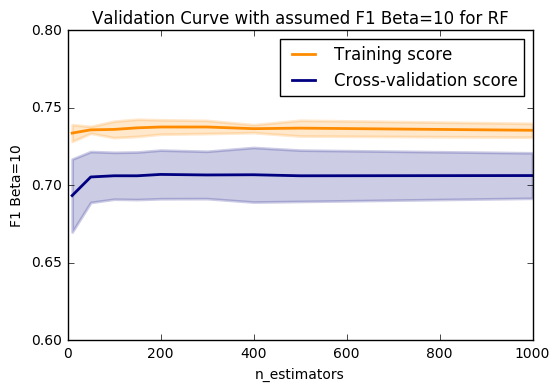

In [45]:
import matplotlib.pyplot as plt
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with assumed F1 Beta=10 for RF")
plt.xlabel("n_estimators")
plt.ylabel("F1 Beta=10")
plt.ylim(0.6, 0.8)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [44]:
test_scores_mean

array([ 0.69341837,  0.70541213,  0.70618633,  0.70617558,  0.70705154,
        0.70670984,  0.70684229,  0.70617986,  0.7063227 ])

## play around with nested cross

In [129]:
from nestedcross import rerun_nested_for_scoring

In [141]:
for estimator in nested_cross.estimators_:
    estimator.scoring = FrankenScorer()

In [142]:
next_ness = rerun_nested_for_scoring(nested_cross, 'assumed_f1', X_train.values, y_train.values, how='max', n_jobs=-1, verbose=100)

Memmaping (shape=(352556, 288), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_6810928\5244-238978720-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to new file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_6810928\5244-238978720-37e9d47f2d553d0c8c1a28b850ef16f7.pkl
Memmaping (shape=(352556, 288), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_6810928\5244-238978720-d47a562ce4fdf84a63c4c4a1b92e0b10.pkl
Memmaping (shape=(352556,), dtype=int64) to old file C:\Users\JEFFRE~1.GOM\AppData\Local\Temp\joblib_memmaping_pool_5244_6810928\5244-238978720-37e9d47f2d553d0c8c1a28b850ef16f7.pkl


PicklingError: Can't pickle <class 'frankenscorer.FrankenScorer'>: it's not the same object as frankenscorer.FrankenScorer

In [123]:
sub_scores = [extract_score_grid(searcher) for searcher in nested_cross.estimators_]

In [124]:
sum_scores_means = [sub_score[[c for c in sub_score.columns if 'test' in c and 'mean' in c]] for sub_score in sub_scores]

In [126]:
pd.DataFrame({'maxidx':sum_scores_means.idxmax(), 'max':sum_scores_means.max(), 'min':sum_scores_means.min(), 'minidx':sum_scores_means.idxmin()})

AttributeError: 'list' object has no attribute 'idxmax'

In [94]:
sum_scores_means.iloc[38]

mean_labeled_acc_test                    0.826918
mean_labeled_recall_test                 0.805031
mean_labeled_f1_test                     0.859867
mean_fp_confusion_matrix_lab_test       25.000000
mean_labeled_brier_test                  0.182926
mean_fn_confusion_matrix_un_test        72.333333
mean_tp_confusion_matrix_lab_test      298.666667
mean_tp_confusion_matrix_un_test       298.666667
mean_tn_confusion_matrix_lab_test      166.333333
mean_confusion_matrix_lab_test                NaN
mean_assumed_f1_test                     0.094290
mean_labeled_brier_neg_test              0.124743
mean_confusion_matrix_un_test                 NaN
mean_assumed_f1beta10_test               0.700463
mean_labeled_prec_test                   0.922851
mean_tn_confusion_matrix_un_test     72309.333333
mean_labeled_roc_auc_test                0.837212
mean_assumed_brier_test                  0.067924
mean_pu_score_test                       8.514120
mean_labeled_brier_pos_test              0.212920


In [96]:
pd.DataFrame(nested_cross.estimators_[0].cv_results_)['params'][38]

{'base_estimator__class_weight': None,
 'base_estimator__max_depth': 29,
 'base_estimator__max_features': 50,
 'base_estimator__min_samples_leaf': 7,
 'base_estimator__min_samples_split': 0.2,
 'base_estimator__n_estimators': 241,
 'num_unlabeled': 1547,
 'pu_learning': True}

In [110]:
est = nested_cross.estimators_[0]

In [111]:
est.estimator

PNUWrapper(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
      num_unlabeled=0.0, pu_learning=False, random_state=828,
      threshold_set_pct=None)